# HEP Discriminator
Anthony Vizcaino Aportela 2021

Many snipets of code are borrowed from the example

# 1)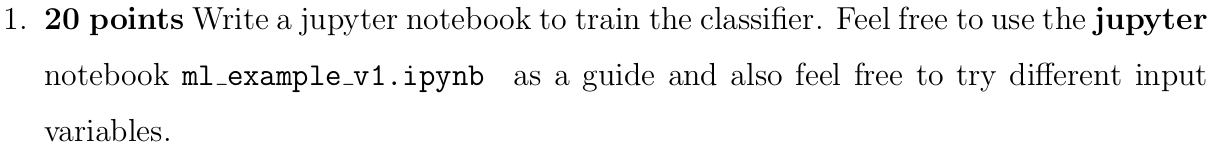

### Import statements

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

#  a function to save results
import joblib as jb

# pytorch
import torch

# pytorch neural network module
import torch.nn as nn

#  split data into a training set and a test set
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

# to reload modules
#import importlib

%matplotlib inline

### Graph settings

In [2]:
# update fonts
FONTSIZE = 20
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE
        }
mp.rc('font', **font)
#mp.rc('xtick', labelsize='x-small')
#mp.rc('ytick', labelsize='x-small')
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility 
# on a given machine
seed = 111
rnd  = np.random.RandomState(seed)

### Load Higgs boson data into memory


In [3]:
train_data = pd.read_csv('datasets/hzz_vbf_ggf_train.csv') 
test_data  = pd.read_csv('datasets/hzz_vbf_ggf_test.csv')
print(len(train_data))
print(len(test_data))
train_data[:5]

50000
10000


,Z1mass,Z2mass,pt4l,eta4l,massjj,detajj,HT,dRZ1Z2,target
0,90.29,14.06,215.80,-0.1829,86.08,0.3362,324.5,0.4905,0.0
1,86.57,37.24,217.80,0.3579,310.20,2.8900,219.9,0.1691,0.0
2,97.37,13.46,138.90,-0.8100,220.40,2.9030,106.3,0.4296,0.0
3,91.96,18.97,54.89,-2.6840,583.50,5.0130,101.6,1.7580,1.0
4,91.45,12.06,187.80,-0.5866,55.98,0.3771,220.2,0.6852,1.0


### Plot data

In [4]:
def plotData(data, 
             xmin=0, xmax=8, 
             ymin=0, ymax=1600, 
             N=1000, ftsize=FONTSIZE):
    
    # set size of figure
    plt.figure(figsize=(6, 6));

    # get axis info
    axes = plt.gca()
    # set axes' limits
    axes.set_xlim(xmin, xmax)
    axes.set_ylim(ymin, ymax)
    
    # annotate axes
    plt.xlabel(r'$\Delta\eta_{jj}$', fontsize=ftsize)
    plt.ylabel(r'$m_{jj}$ (GeV)', fontsize=ftsize)
    
    # split into sig and bkg for the purposes of plotting
    sig = data[data.target > 0.5][:N]
    bkg = data[data.target < 0.5][:N]

    plt.scatter(sig.detajj, sig.massjj, marker='o',
                s=50, c='red', alpha=0.3, label='VBF')
    plt.legend(loc='upper left') # activate legend
    
    plt.scatter(bkg.detajj, bkg.massjj, marker='*',
                s=100, c='blue',  alpha=0.3, label='ggF')
    plt.legend(loc='upper left') # activate legend
    
    plt.savefig('higgs_vbf_ggf.png')
    plt.show()

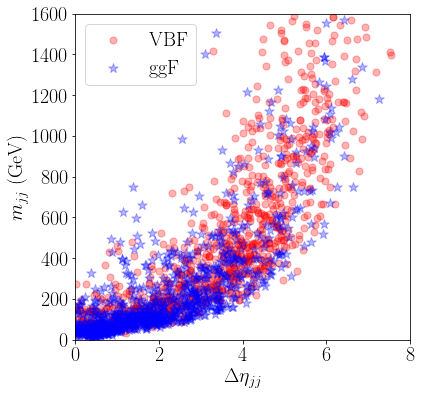

In [5]:
plotData(train_data)

### Prepare data for training/testing

In [6]:
def standardize_data(train_data, test_data, inputs, fraction):
    #for standardizing the data
    scaler  = StandardScaler()
    scaler.fit(train_data[inputs])
    
    #for dilinating a validation set
    train_data, valid_data = train_test_split(train_data, 
                                          test_size=fraction)
    
    #standardizing and transforming the 3 sets into numpy arrays
    train_x = scaler.transform(train_data[inputs])
    train_y = train_data['target']
        
    test_x  = scaler.transform(test_data[inputs])
    test_y  = test_data['target']
    
    valid_x  = scaler.transform(valid_data[inputs])
    valid_y  = valid_data['target']   
    
    tr_x = np.array(train_x).astype(np.float32)
    tr_y = np.array(train_y).astype(np.int64)
    
    te_x = np.array(test_x).astype(np.float32)
    te_y = np.array(test_y).astype(np.int64)
    
    v_x = np.array(valid_x).astype(np.float32)
    v_y = np.array(valid_y).astype(np.int64)

    return (tr_y, tr_x, te_y, te_x, v_y, v_x, scaler)

Here we define the variables we want to train with and curate the datasets. I choose to use every variable available"

In [7]:
inputs = ['Z1mass','Z2mass','pt4l','eta4l','massjj','detajj','HT','dRZ1Z2']
fraction = 1/10
processed_data = standardize_data(train_data, test_data, inputs, fraction)
train_y, train_x, test_y, test_x, valid_y, valid_x, scaler = processed_data

Define various loss functions we might want to use. I notice that L1Loss did the best at seperating the distributions without the AUC decreasing too much.

In [8]:
def CE(y, f):
    # y: target
    # f: model output
    #
    # Note: y and f must be of the same shape. 
    #
    # The following implements a ternary operator:
    #    do-this if condition-is-true else do-that
    #losses = torch.where(y > 0.5, torch.log(f), torch.log(1-f)) #is this a mistake?
    losses = torch.where(y == 1, torch.log(f), torch.log(1-f))
    return -torch.mean(losses) 

def L1Loss(y, f):
    losses = torch.abs(y - f)
    return torch.mean(losses)

def MSE(y, f):
    losses = (y - f)**2
    return torch.mean(losses)

def NLL(y, f):
    losses = -torch.log(f)
    return torch.mean(losses)

def KL(y, f):
    losses = f*(torch.log(f)-y)
    return torch.mean(losses)

Defining accuracy function to see how we're doing

In [9]:
def accuracy(y, f):
    # note: y and f must be of the same shape. 
    # count how many times the predicted target, p, matches 
    # the true target, y. then convert to a fraction.
    f = f.reshape(y.shape)
    p = (f > 0.5).long()   # convert to long ints
    a = (p == y).float()   # convert to floats
    return float(torch.mean(a))

Compute validation measure

In [10]:
def validate(model, targets, inputs):
    # Make sure to set evaluation mode so that training specific
    # operations such as dropout are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and y
        x = torch.from_numpy(inputs)
        y = torch.from_numpy(targets)
        f = model(x)      # predict probabilities p(1|x)
    return accuracy(y, f)

For batch sampling

In [11]:
def get_batch(y, x, batch_size):
    # The numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = rnd.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_y = y[rows]
    return (batch_y, batch_x)

Big training function

In [12]:
def train(model,            # ML model
          optimizer,        # optimizer..duh!
          avloss,           # empirical risk (average loss)
          getbatch,         # function to get a batch of data
          train_y, train_x, # training data
          valid_y, valid_x, # validation data
          batch_size, 
          n_iterations, step=10):
    
    xx   = []    # cache for iteration number
    yy_t = []    # cache for accuracy computed on training data
    yy_v = []    # cache for accuracy computed on validation data
    n    = len(valid_x)
    
    # Set mode to training so that training 
    # specific operations such as dropout are enabled.
    model.train()
    
    print('Accuracy')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    # Training loop
    for ii in range(n_iterations):

        # Get a random sample (a batch) of data (as numpy arrays)
        batch_y, batch_x = getbatch(train_y, train_x, batch_size)
        
        # Convert the numpy arrays batch_y and batch_x, to tensor 
        # types. The PyTorch tensor type is the magic that permits 
        # automatic differentiation with respect to parameters. 
        # However, since we do not need to take the derivatives
        # with respect to x and t, we disable this feature:
        with torch.no_grad(): 
            x = torch.from_numpy(batch_x)
            y = torch.from_numpy(batch_y)     

        # Compute the output of the model for the batch of data 'x'
        # making sure that the shape of outputs is the same as 
        # the shape of targets 'y'.
        outputs = model(x).reshape(y.shape)
        
        # Compute a noisy approximation to the average loss at the
        # current point in the parameter space. Noisy gradients 
        # increase the chance that the optimizer can escape local
        # minima.
        empirical_risk = avloss(y, outputs)
        
        # Use automatic differentiation to compute the
        # noisy approximation of the local gradient.
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # Finally, advance one step in the direction of steepest 
        # descent using the noisy local gradient. 
        optimizer.step()            # move a single step
        
        # print out some "I'm alive info"
        if ii % step == 0:
            # Compute a validation measure using the model 
            # given its current parameters.
            # Make training data the same size as the validation data.
            acc_t = validate(model, train_y[:n], train_x[:n]) 
            acc_v = validate(model, valid_y, valid_x)
            
            # print on same line
            print("\r%10d\t%10.4f\t%10.4f" % (ii, acc_t, acc_v), 
                  end='')
        
            # Update cache
            xx.append(ii)
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
    return (xx, yy_t, yy_v)

Next couple functions are for plotting

In [13]:
def plot_accuracy(traces, gfile='fig_accuracy.png'):
    
    xx, yy_t, yy_v = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(6, 5))
    
    # adjust y limits
    plt.ylim((0, 1))
    plt.xlim((0, xx[-1]))
    
    plt.xlabel('Iterations', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    
    plt.title('Training and Validation Accuracy', 
              color='blue', fontsize=16)
    
    plt.plot(xx, yy_t, 'b', label='Training')
    plt.plot(xx, yy_v, 'r', label='Validation')

    plt.legend(loc='lower right')
    
    plt.grid(True, which="both", linestyle='-')

    plt.tight_layout()
    plt.savefig(gfile)
    plt.show()

In [14]:
def plot_empirical_risk(xx, yy_t, yy_v, 
                        gfile='fig_average_loss.png'):
    
    # create an empty figure
    fig = plt.figure(figsize=(6, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss function", fontsize=16)
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')

    ax.set_xlabel('Iterations', fontsize=FONTSIZE)
    ax.set_ylabel('average loss', fontsize=FONTSIZE)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')
    
    plt.savefig(gfile)
    plt.show()

Defining Model. I noticed that the number and size of layers almost doesn't do anything do I kept it at one hidden layer.

In [15]:
# The sequential class is often sufficient for simple models.
inputLength = len(inputs) # dont forget to have the same length for input layer as input variables
model = nn.Sequential(nn.Linear(inputLength,   150), nn.ReLU(),
                      #nn.Linear(150, 500), nn.ReLU(),
                      #nn.Linear(500, 150), nn.ReLU(),
                      nn.Linear(150,   1), nn.Sigmoid())

print(model)

Sequential(
  (0): Linear(in_features=8, out_features=150, bias=True)
  (1): ReLU()
  (2): Linear(in_features=150, out_features=1, bias=True)
  (3): Sigmoid()
)


Where the training magic happens

In [16]:
n_batch      =    50 # batch size
n_iterations = 20001 # number of iterations

#loss = L1Loss
#loss = CE
loss = MSE

# We'll use the Stochastic Gradient Descent optimizer
# with:
learning_rate= 1.e-3

optimizer = torch.optim.SGD(model.parameters(), 
                            lr=learning_rate, 
                            weight_decay=1.e-5)

traces    = train(model, optimizer, loss, get_batch,
                  train_y, train_x, 
                  valid_y, valid_x,
                  n_batch, n_iterations, step=10)

Accuracy
 iteration	 train-set	 valid-set
     20000	    0.7002	    0.7022

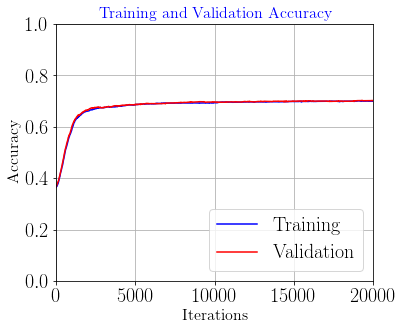

In [17]:
plot_accuracy(traces)

For computing the prob distributions of each choice.

# 2)
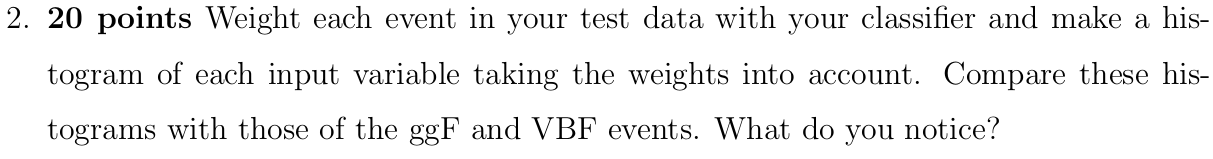

In [18]:
def compute_prob(model, xx):
    
    model.eval() # set to evaluation mode
    
    # convert from numpy array to a torch tensor of type float
    x = torch.from_numpy(xx).float()

    # compute p(1|x)
    p = model(x)
    
    # squeeze() removes extraneous dimensions ([-1, 1] => [-1])
    p = p.squeeze()

    # detach().numpy() converts back to a numpy array
    p = p.detach().numpy()
    
    return p

def compute_partial_prob(model, xx, i):
    
    model.eval() # set to evaluation mode
    
    # convert from numpy array to a torch tensor of type float
    x = torch.from_numpy(xx).float()

    # compute p(1|x)
    p = model(x)
    
    # squeeze() removes extraneous dimensions ([-1, 1] => [-1])
    p = p.squeeze()

    # detach().numpy() converts back to a numpy array
    p = xx[:,i]*p.detach().numpy()
    
    return p

In [19]:
def plot_distributions(y, p):
    ps = p[y > 0.5] # probabilities for class with y == 1
    pb = p[y < 0.5] # probabilities for class with y == 0
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.hist(ps, bins=50, color='b',
            histtype='stepfilled',
            alpha=0.3, label='$VBF$',
            density = True)
    
    ax.hist(pb, bins=50, color='r',
            histtype='stepfilled',
            alpha=0.3, label='$ggF$',
            density = True)
    
    ax.set_xlabel('$p(y=1|x)$', fontsize=FONTSIZE)
    ax.legend(loc='upper right')
    ax.set_yscale('log')
    plt.savefig('fig_dists_complete.png')
    plt.show()
    
def plot_partial_distributions(y, p, i):
    ps = p[y > 0.5] # probabilities for class with y == 1
    pb = p[y < 0.5] # probabilities for class with y == 0
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.hist(ps, bins=50, color='b',
            histtype='stepfilled',
            alpha=0.3, label='$VBF$',
            density = True)
    
    ax.hist(pb, bins=50, color='r',
            histtype='stepfilled',
            alpha=0.3, label='$ggF$',
            density = True)
    
    ax.set_xlabel(inputs[i], fontsize=FONTSIZE)
    ax.legend(loc='upper right')
    ax.set_yscale('log')
    plt.savefig('fig_dists_'+inputs[i]+'.png')
    plt.show()

In [20]:
def plot_roc_curve(y, p):#, p_t):
    
    # compute fraction of class instances that pass
    # different thresholds for y = 0 and y = 1 classes.
    f0, f1, _ = roc_curve(y, p)
    roc_auc   = auc(f0, f1)   # compute area under curve

    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    ax  = fig.add_subplot(1,1,1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel(r'fraction $ggF$', fontsize=18)
    ax.set_ylabel(r'fraction$VBF$', fontsize=18)
    
    ax.plot(f0, f1, color='red',
            lw=1, label='ROC curve, AUC = %0.2f)' % roc_auc)
    
    ax.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')
    ax.legend(loc="lower right", fontsize=14)
    plt.savefig('fig_roc_complete.png')
    plt.show()
    
def plot_partial_roc_curve(y, p, i):#, p_t):
    
    # compute fraction of class instances that pass
    # different thresholds for y = 0 and y = 1 classes.
    f0, f1, _ = roc_curve(y, p)
    roc_auc   = auc(f0, f1)   # compute area under curve

    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    ax  = fig.add_subplot(1,1,1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel(r'fraction $ggF$', fontsize=18)
    ax.set_ylabel(r'fraction$VBF$', fontsize=18)
    
    ax.plot(f0, f1, color='red',
            lw=1, label='ROC curve, AUC = %0.2f)' % roc_auc)
    
    ax.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')
    ax.legend(loc="lower right", fontsize=14)
    ax.set_title(inputs[i])
    plt.savefig('fig_roc_'+inputs[i]+'.png')
    plt.show()

This is good. The more seperated they are, the less ambiguous the choice is. Saved as *complete.png

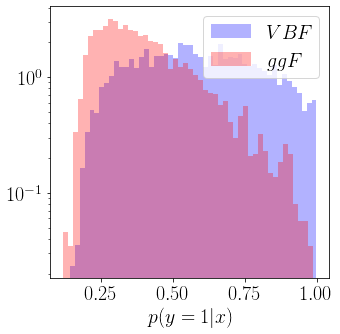

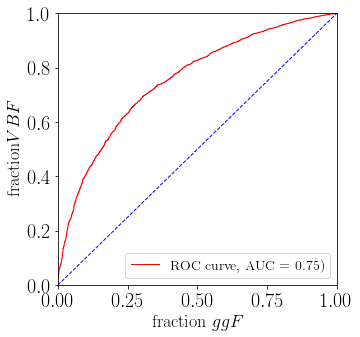

In [21]:
q = compute_prob(model, test_x)
plot_distributions(test_y, q)
plot_roc_curve(test_y, q)

By looking at the rock curves, it seems that massjj and detajj are the main distinguishing features. They are the only ones that are strictly above the center diagonal. On top of this, it seems that the histograms with a disparity, with more of one kind of event on one side, correspond to ROC curves that are predominatly above the center diagonal. These are saved as fig_**_i.png where i runs from 0 to 7.

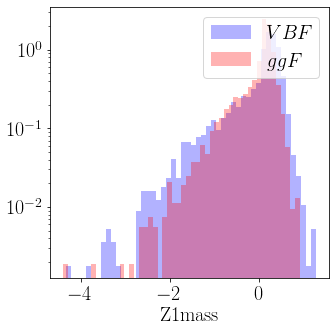

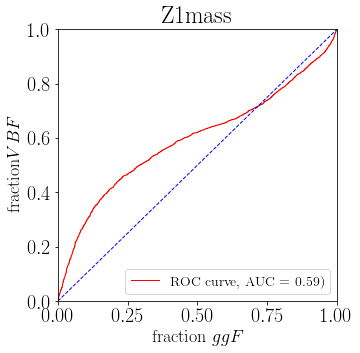

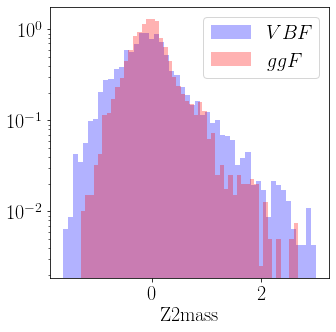

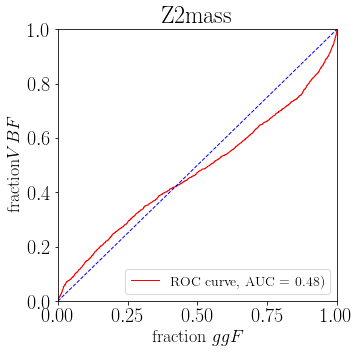

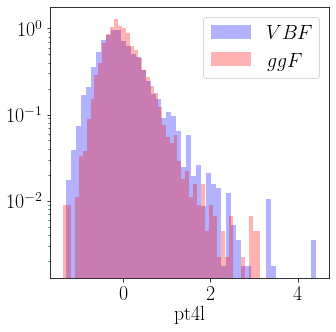

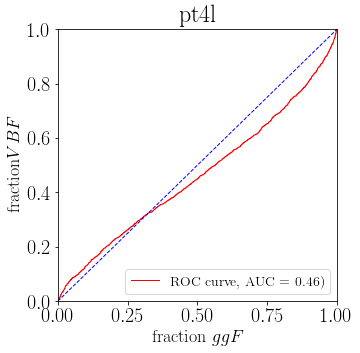

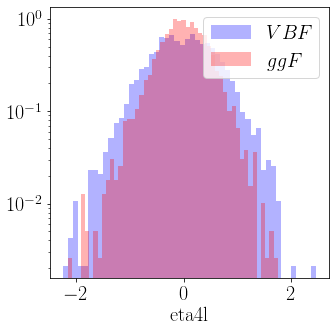

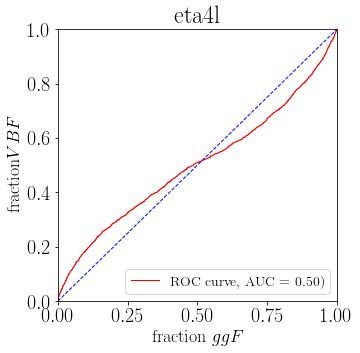

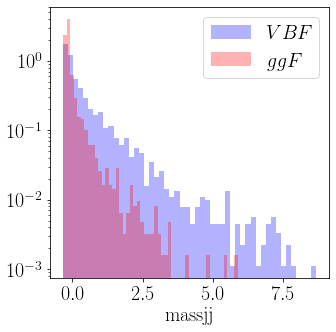

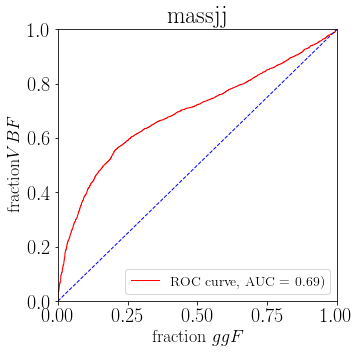

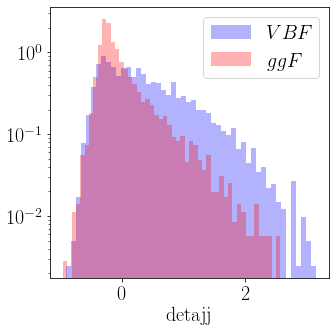

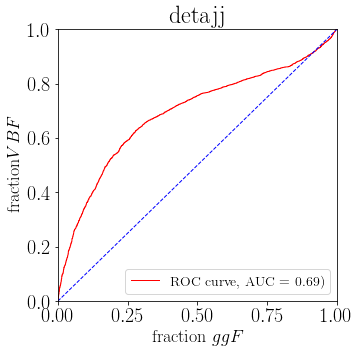

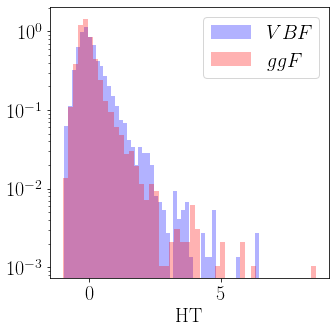

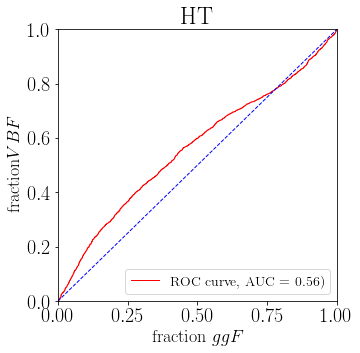

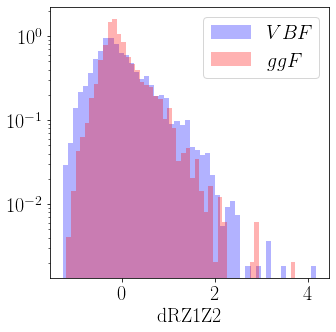

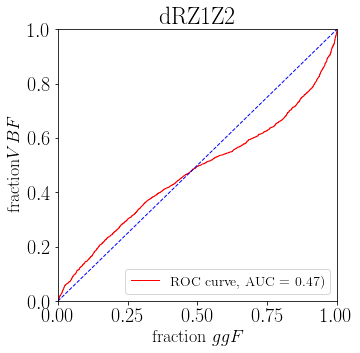

In [22]:
for i in range(len(inputs)):
    p = compute_partial_prob(model, test_x, i)
    plot_partial_distributions(test_y, p, i)
    plot_partial_roc_curve(test_y, p, i)